In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd

# Load dataset utama
application_train = pd.read_csv("home-credit-default-risk/application_train.csv")

# Load dataset pendukung
bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
previous_application = pd.read_csv("home-credit-default-risk/previous_application.csv")
pos_cash_balance = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")
installments_payments = pd.read_csv("home-credit-default-risk/installments_payments.csv")
credit_card_balance = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")

In [4]:
# Agregasi bureau_balance
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'count'],
    'STATUS': 'nunique'  # Contoh jika ingin menghitung jumlah kategori berbeda
}).reset_index()

# Rename kolom hasil agregasi
bureau_balance_agg.columns = ['SK_ID_BUREAU', 'MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_COUNT', 'STATUS_UNIQUE']


In [5]:
bureau = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')


In [6]:
# Agregasi bureau
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': ['sum', 'mean'],  # Total dan rata-rata jumlah kredit
    'DAYS_CREDIT': ['mean', 'min'],    # Rata-rata dan minimum waktu kredit
    'MONTHS_BALANCE_COUNT': 'sum'      # Total data di bureau_balance
}).reset_index()

# Rename kolom hasil agregasi
bureau_agg.columns = ['SK_ID_CURR', 'CREDIT_SUM_TOTAL', 'CREDIT_SUM_AVG', 'DAYS_CREDIT_MEAN', 'DAYS_CREDIT_MIN', 'BUREAU_BALANCE_TOTAL']


In [9]:
application_train = application_train.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [10]:
# Agregasi previous_application
previous_agg = previous_application.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT': ['sum', 'mean'],  # Total dan rata-rata jumlah kredit
    'NAME_CONTRACT_STATUS': 'nunique',  # Jumlah status kontrak unik
    'DAYS_DECISION': ['mean', 'min']   # Waktu keputusan rata-rata
}).reset_index()

# Rename kolom hasil agregasi
previous_agg.columns = ['SK_ID_CURR', 'PREV_CREDIT_TOTAL', 'PREV_CREDIT_AVG', 'CONTRACT_STATUS_UNIQUE', 'DECISION_DAYS_MEAN', 'DECISION_DAYS_MIN']

# Gabungkan ke application_train
application_train = application_train.merge(previous_agg, on='SK_ID_CURR', how='left')


In [11]:
# Agregasi POS_CASH_balance
pos_cash_agg = pos_cash_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'CNT_INSTALMENT': 'sum'
}).reset_index()

# Rename kolom hasil agregasi
pos_cash_agg.columns = ['SK_ID_CURR', 'POS_MONTHS_MIN', 'POS_MONTHS_MAX', 'POS_MONTHS_AVG', 'POS_INSTALMENT_COUNT']

# Gabungkan ke application_train
application_train = application_train.merge(pos_cash_agg, on='SK_ID_CURR', how='left')


In [12]:
# Agregasi installments_payments
installments_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'AMT_PAYMENT': ['sum', 'mean'],  # Total dan rata-rata pembayaran
    'DAYS_ENTRY_PAYMENT': ['mean', 'min'],  # Rata-rata waktu pembayaran
    'NUM_INSTALMENT_VERSION': 'nunique'  # Jumlah versi cicilan unik
}).reset_index()

# Rename kolom hasil agregasi
installments_agg.columns = ['SK_ID_CURR', 'INSTAL_PAYMENT_TOTAL', 'INSTAL_PAYMENT_AVG', 'INSTAL_PAYMENT_DAYS_MEAN', 'INSTAL_PAYMENT_DAYS_MIN', 'INSTAL_VERSION_UNIQUE']

# Gabungkan ke application_train
application_train = application_train.merge(installments_agg, on='SK_ID_CURR', how='left')


In [13]:
# Agregasi credit_card_balance
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min', 'max'],
    'AMT_BALANCE': ['mean', 'sum'],  # Rata-rata dan total saldo
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean'  # Rata-rata limit kredit
}).reset_index()

# Rename kolom hasil agregasi
credit_card_agg.columns = ['SK_ID_CURR', 'CC_MONTHS_MIN', 'CC_MONTHS_MAX', 'CC_BALANCE_MEAN', 'CC_BALANCE_TOTAL', 'CC_CREDIT_LIMIT_MEAN']

# Gabungkan ke application_train
application_train = application_train.merge(credit_card_agg, on='SK_ID_CURR', how='left')


In [14]:
# Cek missing values
missing_values = application_train.isnull().sum()
print(missing_values[missing_values > 0])


AMT_ANNUITY                 12
AMT_GOODS_PRICE            278
NAME_TYPE_SUITE           1292
OWN_CAR_AGE             202929
OCCUPATION_TYPE          96391
                         ...  
CC_MONTHS_MIN           220606
CC_MONTHS_MAX           220606
CC_BALANCE_MEAN         220606
CC_BALANCE_TOTAL        220606
CC_CREDIT_LIMIT_MEAN    220606
Length: 91, dtype: int64


In [16]:
# Pisahkan kolom numerik dan kategorikal
numerical_columns = application_train.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = application_train.select_dtypes(include=['object']).columns

# Imputasi untuk kolom numerik (gunakan median)
application_train[numerical_columns] = application_train[numerical_columns].fillna(application_train[numerical_columns].median())

# Imputasi untuk kolom kategorikal (gunakan 'Unknown')
application_train[categorical_columns] = application_train[categorical_columns].fillna('Unknown')


In [17]:
# Tentukan batas outlier (misalnya, menggunakan IQR)
Q1 = application_train['AMT_CREDIT'].quantile(0.25)
Q3 = application_train['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clipping
application_train['AMT_CREDIT'] = application_train['AMT_CREDIT'].clip(lower_bound, upper_bound)


In [18]:
import numpy as np
# Terapkan log transform
application_train['AMT_CREDIT_LOG'] = application_train['AMT_CREDIT'].apply(lambda x: np.log1p(x))


C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_12380\2874396299.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train['AMT_CREDIT_LOG'] = application_train['AMT_CREDIT'].apply(lambda x: np.log1p(x))


<Axes: xlabel='AMT_CREDIT'>

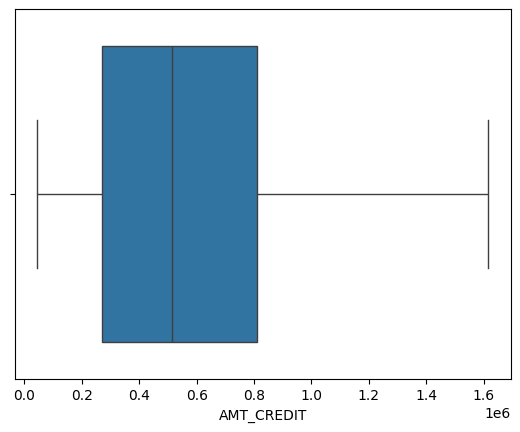

In [19]:
import seaborn as sns
sns.boxplot(x=application_train['AMT_CREDIT'])


0


<Axes: xlabel='AMT_CREDIT'>

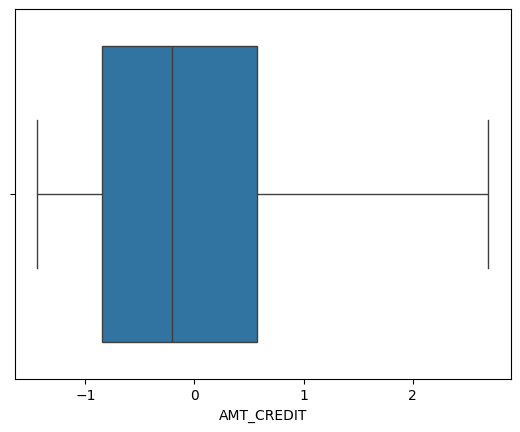

In [32]:
# Cek kembali missing values
print(application_train.isnull().sum().sum())  # Total missing values

# Visualisasi kembali kolom yang telah dibersihkan
import seaborn as sns
sns.boxplot(x=application_train['AMT_CREDIT'])


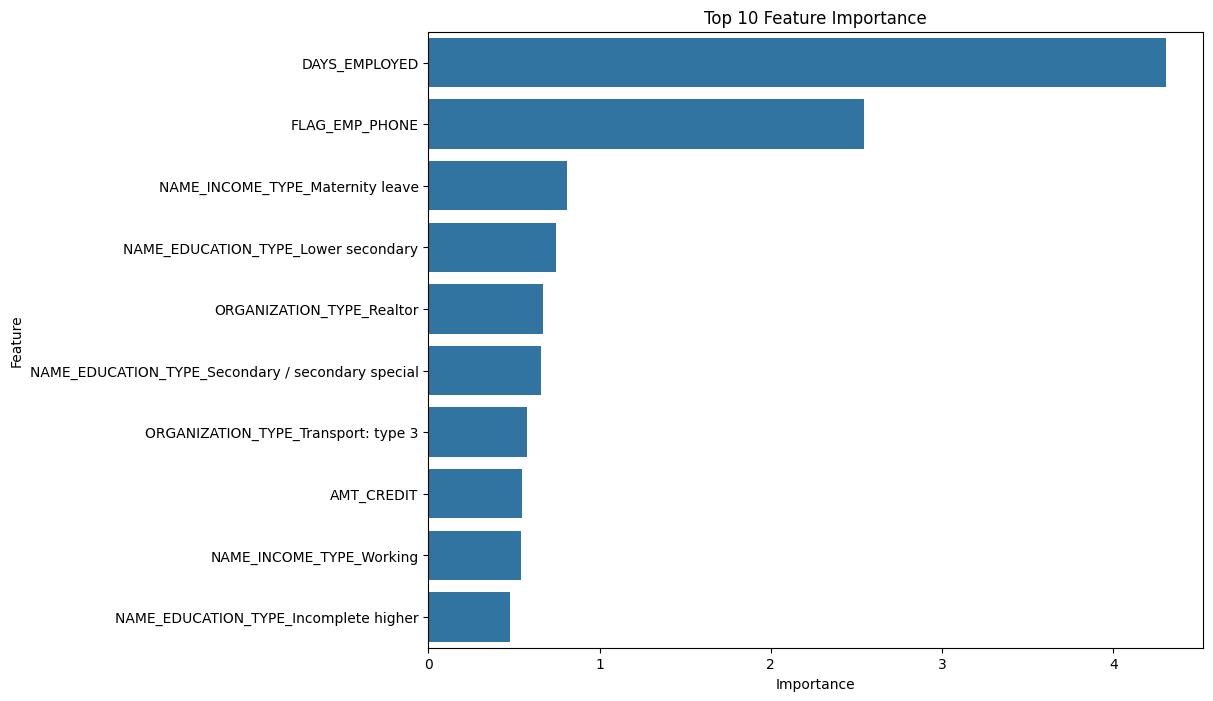

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': logistic_model.coef_[0]
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importance')
plt.show()


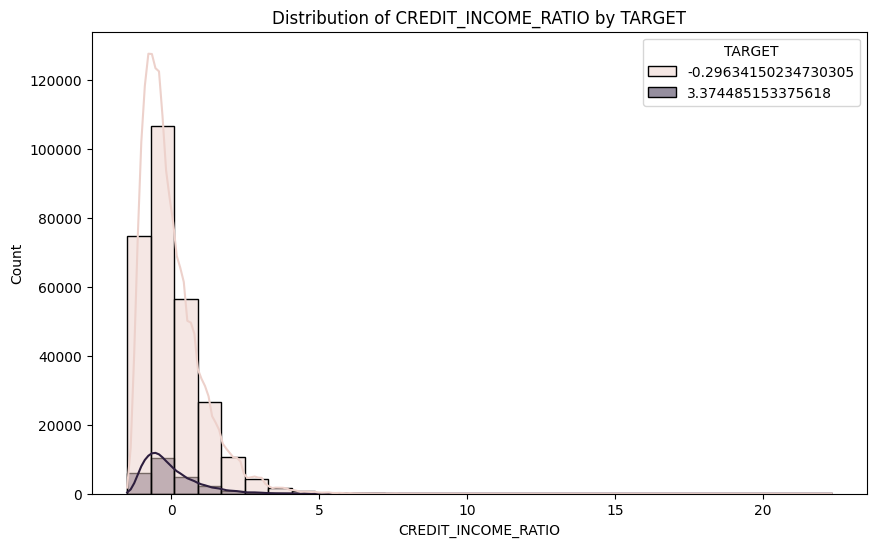

In [35]:
# Contoh analisis distribusi fitur
important_feature = 'CREDIT_INCOME_RATIO'
plt.figure(figsize=(10, 6))
sns.histplot(data=application_train, x=important_feature, hue='TARGET', kde=True, bins=30)
plt.title(f"Distribution of {important_feature} by TARGET")
plt.show()


In [21]:
print(application_train.columns)


Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'INSTAL_PAYMENT_AVG', 'INSTAL_PAYMENT_DAYS_MEAN',
       'INSTAL_PAYMENT_DAYS_MIN', 'INSTAL_VERSION_UNIQUE', 'CC_MONTHS_MIN',
       'CC_MONTHS_MAX', 'CC_BALANCE_MEAN', 'CC_BALANCE_TOTAL',
       'CC_CREDIT_LIMIT_MEAN', 'AMT_CREDIT_LOG'],
      dtype='object', length=147)


In [22]:
# Tampilkan semua kolom kategorikal
categorical_columns = application_train.select_dtypes(include=['object']).columns
print(categorical_columns)


Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [23]:
# Hasilkan dummies untuk semua kolom kategorikal yang ditemukan
application_train = pd.get_dummies(application_train, columns=categorical_columns, drop_first=True)

In [24]:
application_train = pd.get_dummies(application_train, columns=['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_XNA'], drop_first=True)


In [25]:
# Periksa nama kolom yang mirip dengan "NAME_CONTRACT_TYPE" atau "CODE_GENDER"
print([col for col in application_train.columns if 'NAME_CONTRACT_TYPE' in col])
print([col for col in application_train.columns if 'CODE_GENDER' in col])


['NAME_CONTRACT_TYPE_Revolving loans_True']
['CODE_GENDER_M', 'CODE_GENDER_XNA_True']


In [26]:
# Contoh Feature Engineering
application_train['CREDIT_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_train['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
application_train['CREDIT_TERM'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']


C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_12380\1304770722.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train['CREDIT_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_12380\1304770722.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_12380\13

In [27]:
from sklearn.preprocessing import StandardScaler

# Tentukan fitur numerik
numerical_features = application_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
application_train[numerical_features] = scaler.fit_transform(application_train[numerical_features])


In [30]:
# Fitur dan Target
X = application_train.drop(columns=['TARGET', 'SK_ID_CURR'])  # Fitur
y = application_train['TARGET']  # Target

# Pastikan TARGET tidak memiliki missing values
if y.isnull().sum() > 0:
    print(f"Missing values in TARGET: {y.isnull().sum()}")
    application_train = application_train[~application_train['TARGET'].isnull()]
    X = application_train.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = application_train['TARGET']

# Pastikan TARGET bertipe integer
y = y.astype(int)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Inisialisasi model Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

# Prediksi
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Evaluasi
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)
print(classification_report(y_test, y_pred))


ROC-AUC Score: 0.7552712277101815
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           3       0.53      0.02      0.04      4949

    accuracy                           0.92     61503
   macro avg       0.72      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



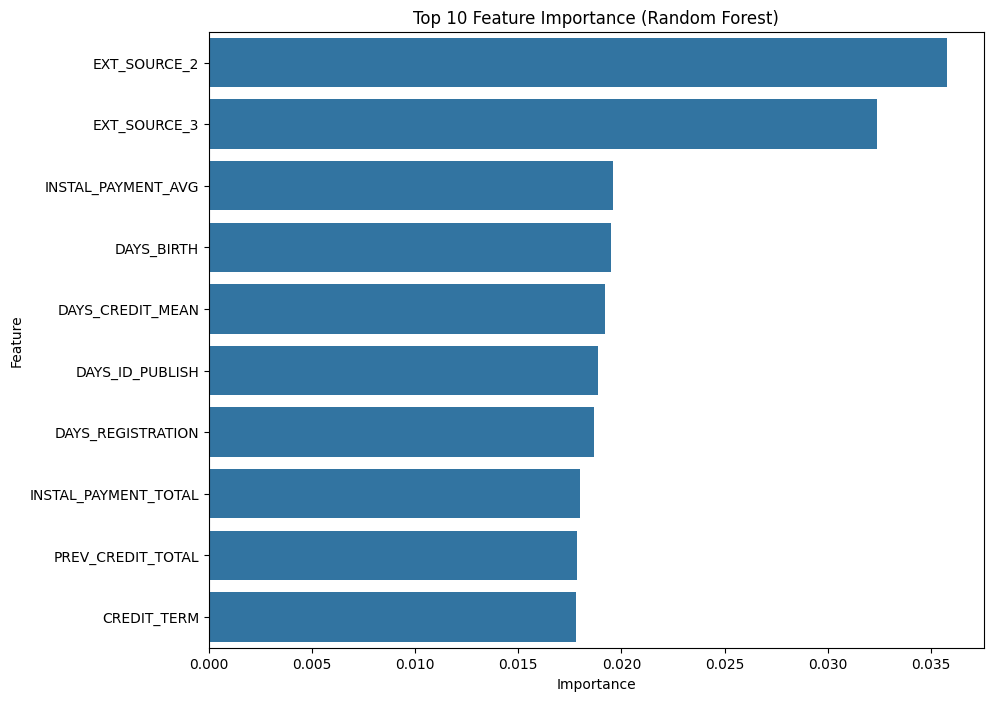

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Latih Random Forest sebagai model untuk melihat feature importance
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Ekstrak feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Feature Importance (Random Forest)")
plt.show()
